In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast


## Load data

In [15]:
PG_df = pd.read_csv('/content/drive/MyDrive/low_d/PG_df.csv')
ADMM_df = pd.read_csv('/content/drive/MyDrive/low_d/ADMM_df.csv')
GoDec_df = pd.read_csv('/content/drive/MyDrive/low_d/GoDec_df.csv')


PG_ticks = [
    '0.8*lambda, 0.8*gamma', '0.8*lambda, gamma', '0.8*lambda, 1.2*gamma',
    'lambda, 0.8*gamma', 'lambda, gamma', 'lambda, 1.2*gamma',
    '1.2*lambda, 0.8*gamma', '1.2*lambda, gamma', '1.2*lambda, 1.2*gamma'
]

ADMM_ticks = [
    'lambda, 0.1*mu', 'lambda, mu', 'lambda, 10*mu',
    '2*lambda, 0.1*mu', '2*lambda, mu', '2*lambda, 10*mu',
    '3*lambda, 0.1*mu', '3*lambda, mu', '3*lambda, 10*mu'
]

GeoDec_ticks = [
    'rank_r(0.85), k(0.005)', 'rank_r(0.85), k(0.01)', 'rank_r(0.85), k(0.05)',
    'rank_r(0.95), k(0.005)', 'rank_r(0.95), k(0.01)', 'rank_r(0.95), k(0.05)',
    'rank_r(0.99), k(0.005)', 'rank_r(0.99), k(0.01)', 'rank_r(0.99), k(0.05)',
]

## Intra-solver evaluation

### Display one feature over the 9 hyper-parameters combinations

In [16]:
def get_last_value(residual_str):
    residual_list = ast.literal_eval(residual_str)
    return residual_list[-1]


def intra_comp(result_df, x_ticks, plot):

  result_df['group'] = (result_df.index % 9) + 1
  result_df['last_residual'] = result_df['residual'].apply(get_last_value)

  col_list = ['tp', 'fp', 'fn', 'precision', 'recall', 'f1', 'elapsed_time', 'sparsity', 'reconstruction_error', 'energy_ratio', 'last_residual']


  avg_per_param = []
  for col in col_list:
    grouped = result_df.groupby('group')[col].agg(['mean', 'count', list]).reset_index()
    grouped['group'] = grouped['group'].astype(str)

    bar_plot_values = grouped['mean'].values
    individual_values = grouped['list'].values

    avg_per_param.append([col, bar_plot_values, individual_values])

    if plot == True:
      plt.figure(figsize=(10, 6))
      plt.bar(grouped['group'], bar_plot_values, color='lightblue', label=f'Mean {col}')

      for idx, values in enumerate(individual_values):
          plt.scatter([grouped['group'][idx]] * len(values), values, color='black', alpha=0.7)

      plt.xlabel('Parameter Combinations (param1, param2)')
      plt.ylabel(col)
      plt.title(f'Mean and Individual {col} Values per Group')
      plt.xticks(ticks=grouped['group'], labels=x_ticks, rotation=45)
      plt.legend()
      plt.tight_layout()
      plt.show()

  return avg_per_param


In [17]:
avg_per_param_PG = intra_comp(PG_df, PG_ticks, plot=False)
avg_per_param_ADMM = intra_comp(ADMM_df, ADMM_ticks, plot=False)
avg_per_param_GeoDec = intra_comp(GoDec_df, GeoDec_ticks, plot=False)

### Display multiple features over the 9 hyper-parameters combinations

In [18]:
def plot_multiple_metrics(PG_df, ADMM_df, GoDec_df, metrics):
    dataframes = {'PG': PG_df, 'ADMM': ADMM_df, 'GoDec': GoDec_df}
    num_metrics = len(metrics)
    x_labels = []

    # Collect means and individuals
    mean_data = {name: [] for name in dataframes}
    individual_data = {name: [] for name in dataframes}

    for metric in metrics:
        for name, df in dataframes.items():
            if metric not in df.columns:
                print(f"Metric '{metric}' not found in {name}")
                return
            values = df[metric].dropna()
            mean_data[name].append(values.mean())
            individual_data[name].append(values)

    # Plot
    x = range(num_metrics)
    bar_width = 0.25
    offset = {'PG': -bar_width, 'ADMM': 0, 'GoDec': bar_width}
    colors = {'PG': 'skyblue', 'ADMM': 'lightgreen', 'GoDec': 'salmon'}

    plt.figure(figsize=(12, 6))

    for name in dataframes:
        plt.bar(
            [i + offset[name] for i in x],
            mean_data[name],
            width=bar_width,
            label=f'{name} (mean)',
            color=colors[name]
        )
        for i, values in enumerate(individual_data[name]):
            plt.scatter(
                [i + offset[name]] * len(values),
                values,
                color='black',
                alpha=0.5,
                s=10,
                label='Individual values' if i == 0 and name == 'PG' else None
            )

    plt.xticks(ticks=x, labels=metrics)
    plt.ylabel("Metric Value")
    plt.title("Comparison of Metrics Across Methods")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [21]:
def intra_comp2(result_df, x_ticks, title, plot):

    result_df['group'] = (result_df.index % 9) + 1
    result_df['last_residual'] = result_df['residual'].apply(get_last_value)

    col_list = ['tp', 'fp', 'fn', 'precision', 'recall', 'f1', 'elapsed_time', 'sparsity', 'reconstruction_error', 'energy_ratio', 'last_residual']
    avg_per_param = []

    # Special handling for precision & recall grouped bar
    if plot:
        grouped = result_df.groupby('group')[['precision', 'recall']].agg(['mean', list]).reset_index()
        grouped['group'] = grouped['group'].astype(str)

        precision_means = grouped[('precision', 'mean')].values
        recall_means = grouped[('recall', 'mean')].values
        precision_vals = grouped[('precision', 'list')].values
        recall_vals = grouped[('recall', 'list')].values

        avg_per_param.append(['precision', precision_means, precision_vals])
        avg_per_param.append(['recall', recall_means, recall_vals])

        bar_width = 0.35
        x = range(len(grouped))
        x_labels = x_ticks

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar([i - bar_width / 2 for i in x], precision_means, width=bar_width, label='Precision', color='lightsteelblue')
        ax.bar([i + bar_width / 2 for i in x], recall_means, width=bar_width, label='Recall', color='slategrey')

        for idx in x:
            ax.scatter([idx - bar_width / 2] * len(precision_vals[idx]), precision_vals[idx], color='black', alpha=0.6)
            ax.scatter([idx + bar_width / 2] * len(recall_vals[idx]), recall_vals[idx], color='black', alpha=0.6)

        #ax.set_xlabel('Parameter Combinations (param1, param2)')
        ax.set_ylabel('Value')
        ax.set_title(f'Precision and Recall: {title} solver')
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45)
        ax.legend()
        plt.tight_layout()
        plt.show()

    return avg_per_param


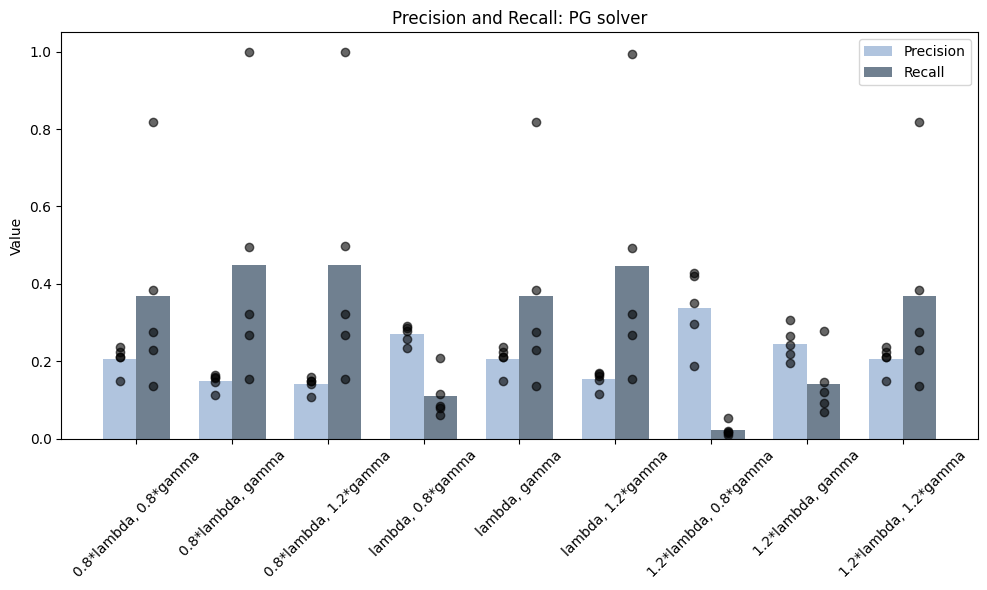

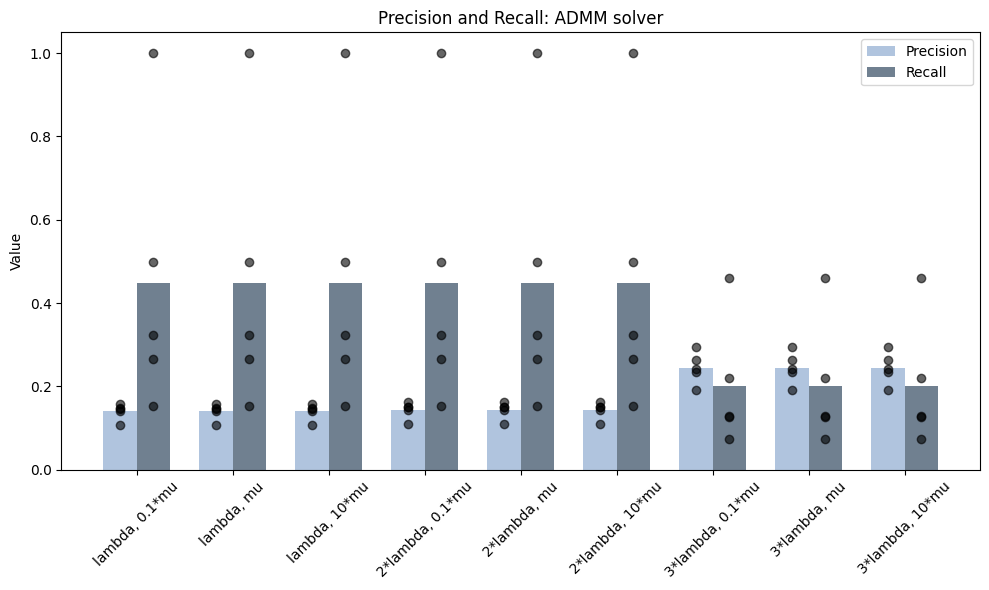

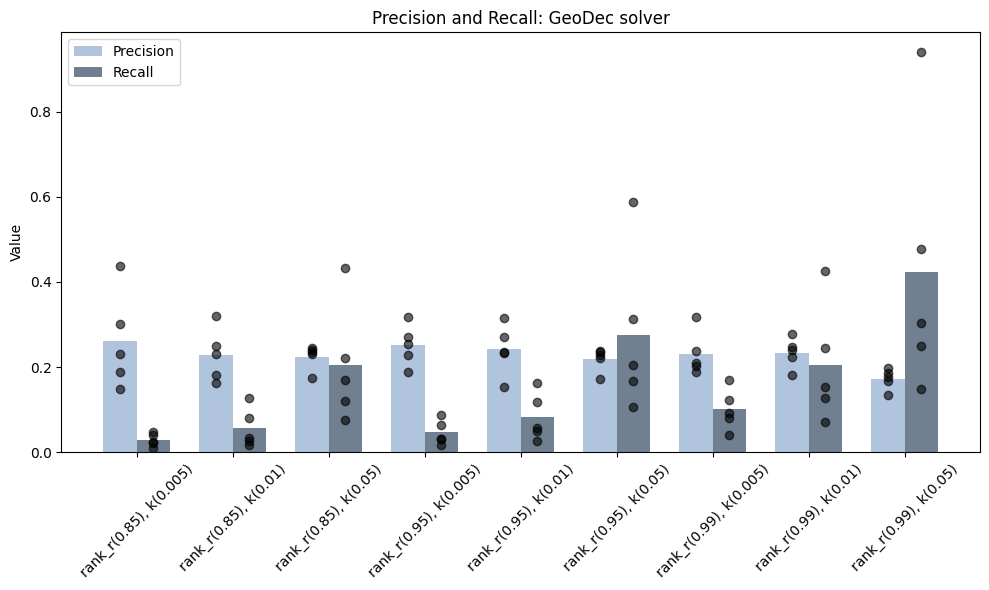

In [22]:
prec_and_recall_PG = intra_comp2(PG_df, PG_ticks, 'PG', plot=True)
prec_and_recall_ADMM = intra_comp2(ADMM_df, ADMM_ticks, 'ADMM', plot=True)
prec_and_recall_GoDec = intra_comp2(GoDec_df, GeoDec_ticks, 'GeoDec', plot=True)

## Inter-solver evaluation

In [19]:
import matplotlib.pyplot as plt
import math

def plot_multiple_metrics_side_by_side(PG_df, ADMM_df, GoDec_df, metrics):
    colors = {'PG': 'skyblue', 'ADMM': 'lightgreen', 'GoDec': 'salmon'}
    num_metrics = len(metrics)
    rows = math.ceil(num_metrics / 2)
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(8, 3 * rows), sharey=False)
    axes = axes.flatten()  # flatten in case of multiple rows

    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Check column exists
        for df_name, df in zip(['PG_df', 'ADMM_df', 'GoDec_df'], [PG_df, ADMM_df, GoDec_df]):
            if metric not in df.columns:
                print(f"Column '{metric}' not found in {df_name}.")
                continue

        pg_vals = PG_df[metric].dropna()
        admm_vals = ADMM_df[metric].dropna()
        godec_vals = GoDec_df[metric].dropna()

        means = [pg_vals.mean(), admm_vals.mean(), godec_vals.mean()]
        labels = ['PG', 'ADMM', 'GoDec']
        all_values = [pg_vals, admm_vals, godec_vals]

        bar_colors = [colors[label] for label in labels]
        ax.bar(labels, means, color=bar_colors, label='Mean')

        for j, (label, values) in enumerate(zip(labels, all_values)):
            x_coords = [j] * len(values)
            ax.scatter(x_coords, values, color='black', alpha=0.6, label='Individual' if j == 0 else None)

        ax.set_title(metric)
        ax.set_ylabel(f'{metric}')
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels)

    # Hide unused axes if metrics < total subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


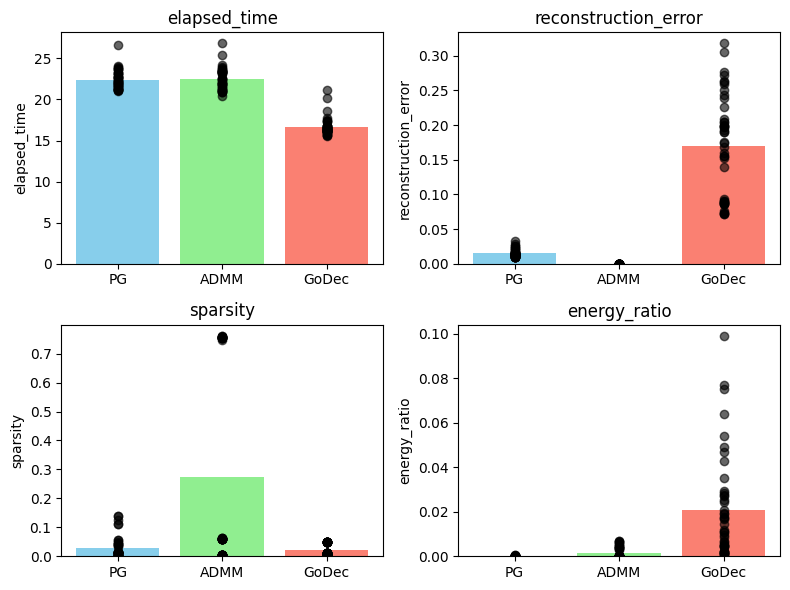

In [20]:
metrics = ['elapsed_time', 'reconstruction_error', 'sparsity', 'energy_ratio']
plot_multiple_metrics_side_by_side(PG_df, ADMM_df, GoDec_df, metrics)

## Best perfoming combination resulting objective function

In [23]:
def summarize_precision_recall(avg_per_param):
    summary = []
    for metric_name, _, individual_values in avg_per_param:
        if metric_name in ['precision', 'recall']:
            for group_idx, group_vals in enumerate(individual_values, start=1):
                mean_val = np.mean(group_vals)
                std_val = np.std(group_vals)
                summary.append({
                    'metric': metric_name,
                    'group': group_idx,
                    'mean': mean_val,
                    'std': std_val
                })

    return pd.DataFrame(summary)

summary_df = summarize_precision_recall(prec_and_recall_PG)
print(summary_df)

       metric  group      mean       std
0   precision      1  0.205931  0.030032
1   precision      2  0.147642  0.018908
2   precision      3  0.140368  0.017524
3   precision      4  0.269539  0.021286
4   precision      5  0.205931  0.030032
5   precision      6  0.152777  0.019967
6   precision      7  0.336684  0.089023
7   precision      8  0.245165  0.038219
8   precision      9  0.205931  0.030032
9      recall      1  0.368213  0.238397
10     recall      2  0.447493  0.297461
11     recall      3  0.448171  0.297572
12     recall      4  0.109806  0.052773
13     recall      5  0.368213  0.238397
14     recall      6  0.445463  0.294843
15     recall      7  0.022524  0.016219
16     recall      8  0.140712  0.072919
17     recall      9  0.368213  0.238397


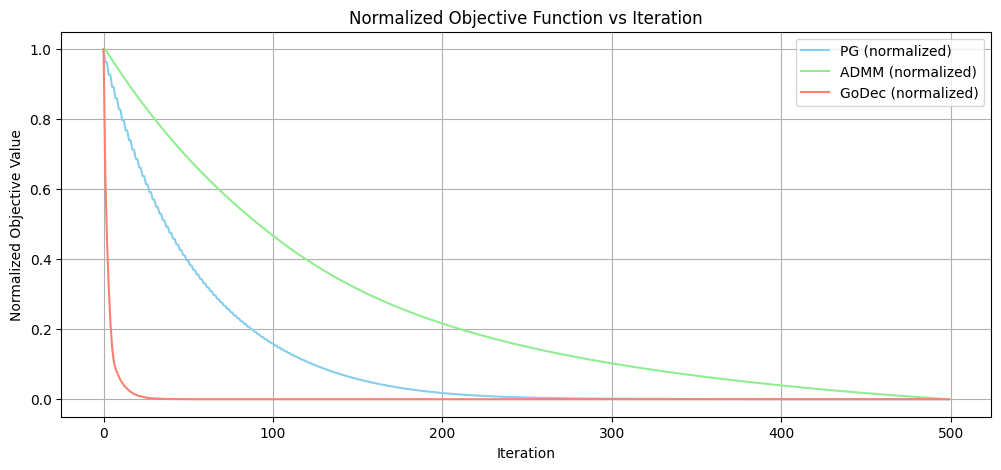

In [24]:
obj_PG = PG_df[PG_df['group'] == 6].iloc[0, 17]
obj_PG = ast.literal_eval(obj_PG)

obj_ADMM = ADMM_df[ADMM_df['group'] == 3].iloc[0, 17]
obj_ADMM = ast.literal_eval(obj_ADMM)

obj_GeoDec = GoDec_df[GoDec_df['group'] == 6].iloc[0, 17]
obj_GeoDec = ast.literal_eval(obj_GeoDec)

def normalize(arr):
    arr = np.array(arr)
    return (arr - arr.min()) / (arr.max() - arr.min())

norm_PG = normalize(obj_PG)
norm_ADMM = normalize(obj_ADMM)
norm_GoDec = normalize(obj_GeoDec)

plt.figure(figsize=(12, 5))
plt.plot(norm_PG, color='skyblue', label='PG (normalized)')
plt.plot(norm_ADMM, color='lightgreen', label='ADMM (normalized)')
plt.plot(norm_GoDec, color='salmon', label='GoDec (normalized)')
plt.xlabel('Iteration')
plt.ylabel('Normalized Objective Value')
plt.title('Normalized Objective Function vs Iteration')
plt.grid(True)
plt.legend()
plt.show()


## Recall and precision over submatrix size

In [25]:
PG_time_df = pd.read_csv('/content/drive/MyDrive/low_d/PG_time_df.csv')
GoDec_time_df = pd.read_csv('/content/drive/MyDrive/low_d/GoDec_time_df.csv')
ADMM_time_df = pd.read_csv('/content/drive/MyDrive/low_d/ADMM_time_df.csv')

def get_param_evol(time_df):
  time_df['group'] = (time_df.index % 9) + 1
  time_df_precision = time_df[time_df['group'] == 6].iloc[:,8].tolist()
  time_df_recall = time_df[time_df['group'] == 6].iloc[:,9].tolist()

  return time_df_precision, time_df_recall

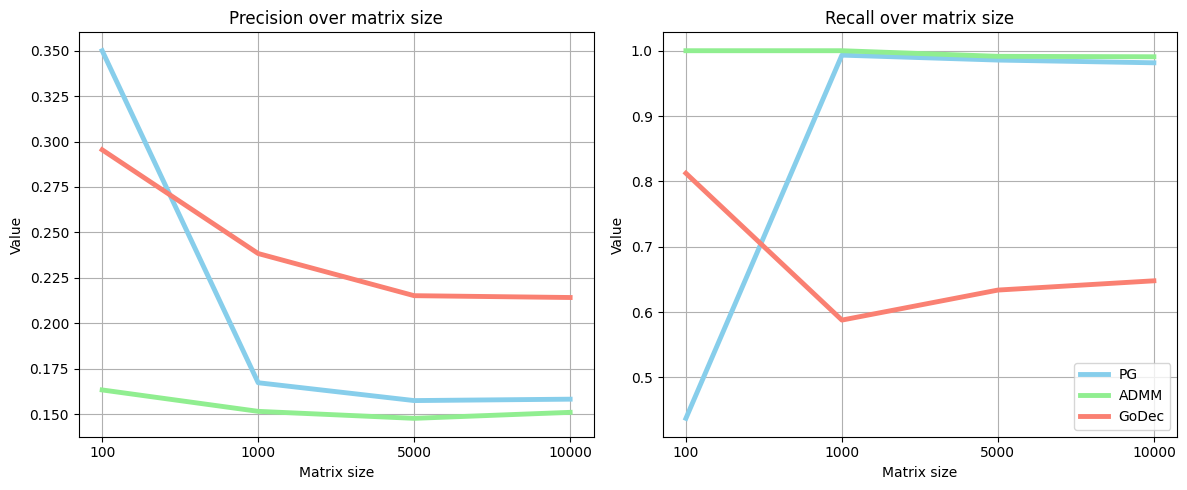

In [26]:
PG_precision, PG_recall = get_param_evol(PG_time_df)
ADMM_precision, ADMM_recall = get_param_evol(ADMM_time_df)
GoDec_precision, GoDec_recall = get_param_evol(GoDec_time_df)

param_labels = ['100', '1000', '5000', '10000']
x = np.arange(len(PG_precision))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(PG_precision, color='skyblue', linewidth=3.5, label='PG')
axes[0].plot(ADMM_precision, color='lightgreen', linewidth=3.5, label='ADMM')
axes[0].plot(GoDec_precision, color='salmon', linewidth=3.5, label='GoDec')
axes[0].set_xlabel('Matrix size')
axes[0].set_ylabel('Value')
axes[0].set_xticks(x)
axes[0].set_xticklabels(param_labels)
axes[0].set_title('Precision over matrix size')
#axes[0].legend()
axes[0].grid(True)

axes[1].plot(PG_recall, color='skyblue', linewidth=3.5, label='PG')
axes[1].plot(ADMM_recall, color='lightgreen', linewidth=3.5, label='ADMM')
axes[1].plot(GoDec_recall, color='salmon', linewidth=3.5, label='GoDec')
axes[1].set_xlabel('Matrix size')
axes[1].set_ylabel('Value')
axes[1].set_xticks(x)
axes[1].set_xticklabels(param_labels)
axes[1].set_title('Recall over matrix size')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

